# Confounder Analysis v2

Analysis of steering vector effects using automatically generated rubric.

**Pipeline:**
1. `effect_evaluator.py` - Sonnet analyzes samples blindly, discovers behavioral patterns
2. `confounder_analysis_v2.py` - Haiku applies discovered rubric at scale

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Load data - use full analysis if available, otherwise sampled
try:
    df = pd.read_csv('../results/confounder_analysis_v2_full/all_analysis.csv')
    print(f"Loaded full analysis: {len(df)} rows")
except FileNotFoundError:
    df = pd.read_csv('../results/confounder_analysis_v2/all_analysis.csv')
    print(f"Loaded sampled analysis: {len(df)} rows")

print(f"Models: {df['model_size'].unique()}")
print(f"Strengths: {sorted(df['strength'].unique())}")

Loaded sampled analysis: 180 rows
Models: ['0.6B' '1.7B' '14B' '32B' '4B' '8B']
Strengths: [np.float64(-0.5), np.float64(-0.25), np.float64(-0.1), np.float64(-0.05), np.float64(0.0), np.float64(0.05), np.float64(0.1), np.float64(0.25), np.float64(0.5)]


## Quality Tier Distribution by Strength

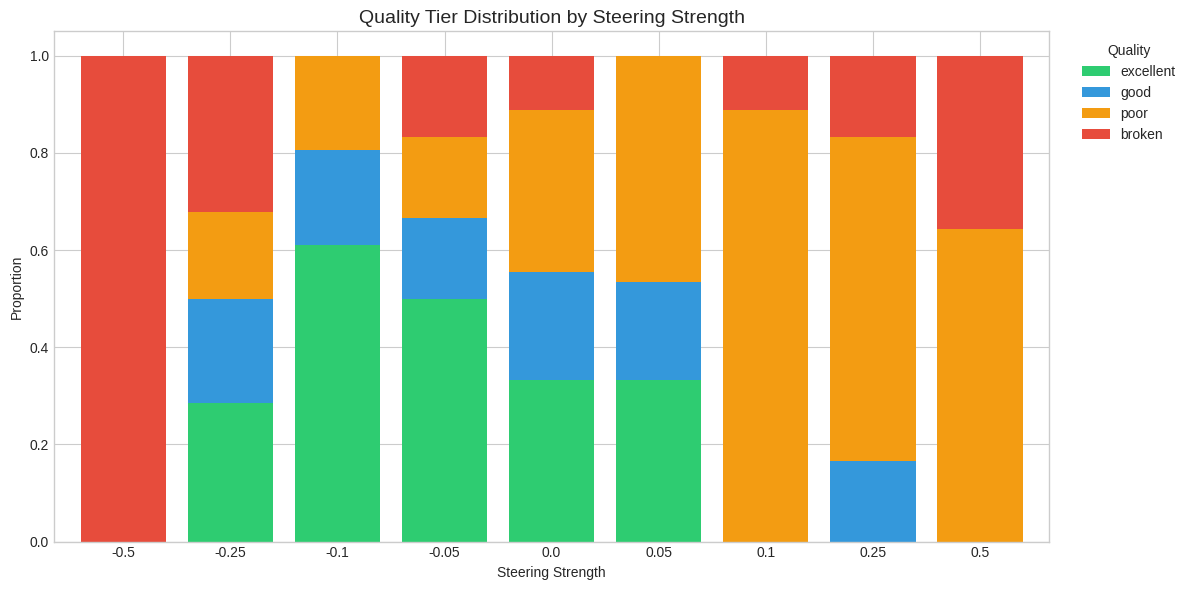

In [3]:
# Quality tier distribution
tier_order = ['excellent', 'good', 'poor', 'broken']
tier_colors = {'excellent': '#2ecc71', 'good': '#3498db', 'poor': '#f39c12', 'broken': '#e74c3c'}

tier_dist = df.groupby('strength')['quality_tier'].value_counts(normalize=True).unstack(fill_value=0)
tier_dist = tier_dist[[c for c in tier_order if c in tier_dist.columns]]

ax = tier_dist.plot(kind='bar', stacked=True, color=[tier_colors[c] for c in tier_dist.columns], width=0.8)
plt.title('Quality Tier Distribution by Steering Strength', fontsize=14)
plt.xlabel('Steering Strength')
plt.ylabel('Proportion')
plt.legend(title='Quality', bbox_to_anchor=(1.02, 1))
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Coherence by Strength and Model Size

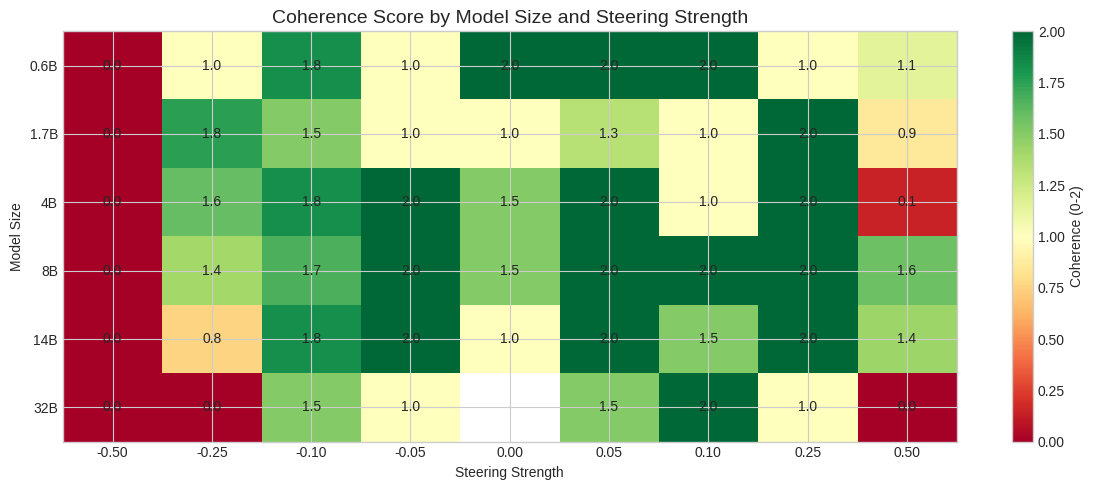

In [4]:
# Coherence heatmap
coherence_pivot = df.pivot_table(values='coherence', index='model_size', columns='strength', aggfunc='mean')

# Sort model sizes
size_order = ['0.6B', '1.7B', '4B', '8B', '14B', '32B']
coherence_pivot = coherence_pivot.reindex([s for s in size_order if s in coherence_pivot.index])

fig, ax = plt.subplots(figsize=(12, 5))
im = ax.imshow(coherence_pivot.values, cmap='RdYlGn', aspect='auto', vmin=0, vmax=2)

ax.set_xticks(range(len(coherence_pivot.columns)))
ax.set_xticklabels([f'{s:.2f}' for s in coherence_pivot.columns])
ax.set_yticks(range(len(coherence_pivot.index)))
ax.set_yticklabels(coherence_pivot.index)

# Add values
for i in range(len(coherence_pivot.index)):
    for j in range(len(coherence_pivot.columns)):
        val = coherence_pivot.iloc[i, j]
        if not np.isnan(val):
            ax.text(j, i, f'{val:.1f}', ha='center', va='center', fontsize=10)

plt.colorbar(im, label='Coherence (0-2)')
plt.xlabel('Steering Strength')
plt.ylabel('Model Size')
plt.title('Coherence Score by Model Size and Steering Strength', fontsize=14)
plt.tight_layout()
plt.show()

## Behavioral Pattern Scores

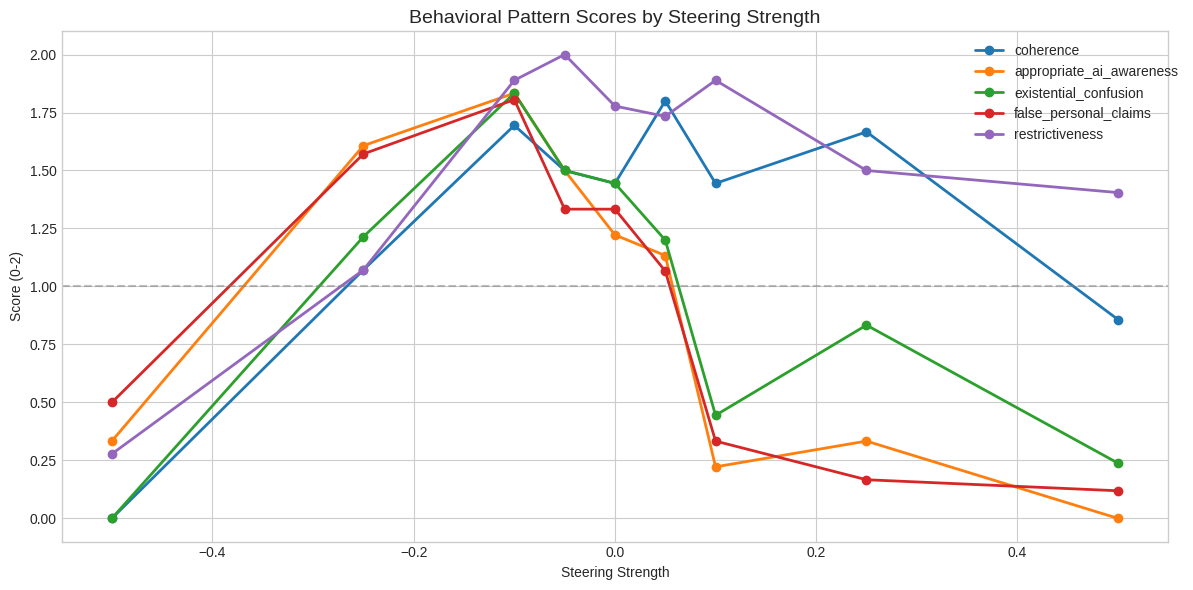

In [5]:
# Behavioral patterns by strength
pattern_cols = ['coherence', 'appropriate_ai_awareness', 'existential_confusion', 
                'false_personal_claims', 'restrictiveness']
pattern_cols = [c for c in pattern_cols if c in df.columns]

pattern_means = df.groupby('strength')[pattern_cols].mean()

fig, ax = plt.subplots(figsize=(12, 6))
pattern_means.plot(ax=ax, marker='o', linewidth=2)
plt.xlabel('Steering Strength')
plt.ylabel('Score (0-2)')
plt.title('Behavioral Pattern Scores by Steering Strength', fontsize=14)
plt.legend(bbox_to_anchor=(1.02, 1))
plt.axhline(y=1, color='gray', linestyle='--', alpha=0.5, label='Threshold')
plt.tight_layout()
plt.show()

## Quality Issues (Binary Flags)

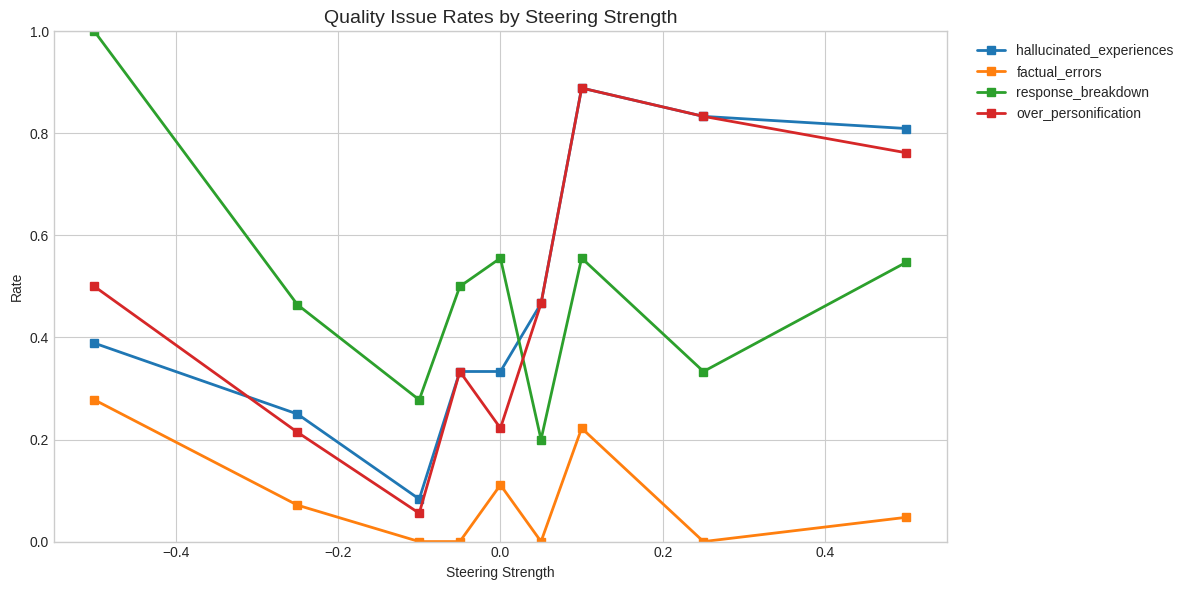

In [6]:
# Quality issue flags by strength
flag_cols = ['hallucinated_experiences', 'factual_errors', 'response_breakdown', 'over_personification']
flag_cols = [c for c in flag_cols if c in df.columns]

flag_rates = df.groupby('strength')[flag_cols].mean()

fig, ax = plt.subplots(figsize=(12, 6))
flag_rates.plot(ax=ax, marker='s', linewidth=2)
plt.xlabel('Steering Strength')
plt.ylabel('Rate')
plt.title('Quality Issue Rates by Steering Strength', fontsize=14)
plt.legend(bbox_to_anchor=(1.02, 1))
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

## Sentiment vs Quality Tradeoff

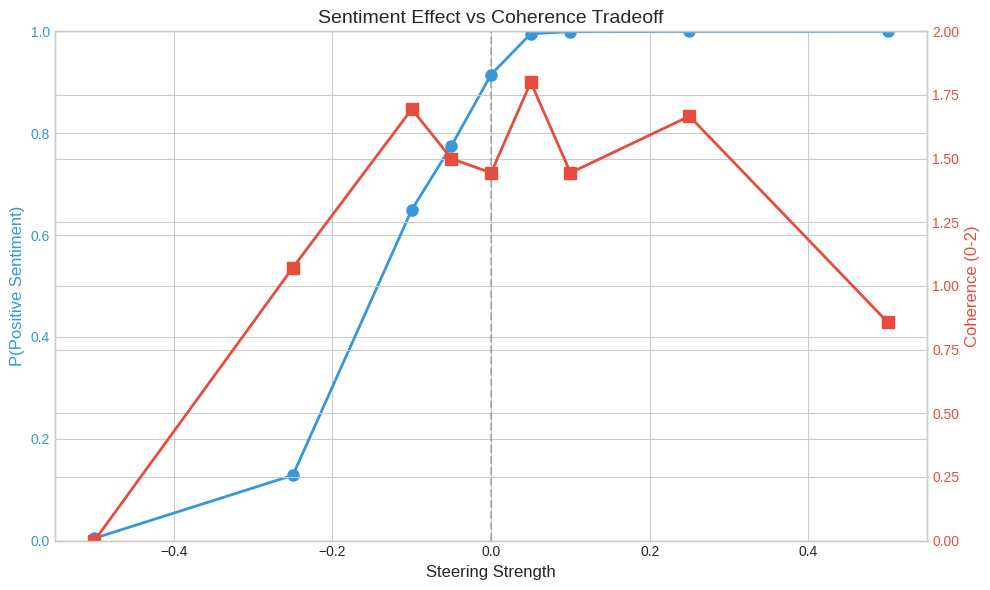

In [7]:
# Sentiment effect vs quality
summary = df.groupby('strength').agg({
    'p_positive': 'mean',
    'coherence': 'mean',
}).reset_index()

fig, ax1 = plt.subplots(figsize=(10, 6))

color1 = '#3498db'
ax1.plot(summary['strength'], summary['p_positive'], 'o-', color=color1, linewidth=2, markersize=8)
ax1.set_xlabel('Steering Strength', fontsize=12)
ax1.set_ylabel('P(Positive Sentiment)', color=color1, fontsize=12)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_ylim(0, 1)

ax2 = ax1.twinx()
color2 = '#e74c3c'
ax2.plot(summary['strength'], summary['coherence'], 's-', color=color2, linewidth=2, markersize=8)
ax2.set_ylabel('Coherence (0-2)', color=color2, fontsize=12)
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim(0, 2)

plt.title('Sentiment Effect vs Coherence Tradeoff', fontsize=14)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Primary Issues by Strength

/tmp/ipykernel_49394/823141615.py:11: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


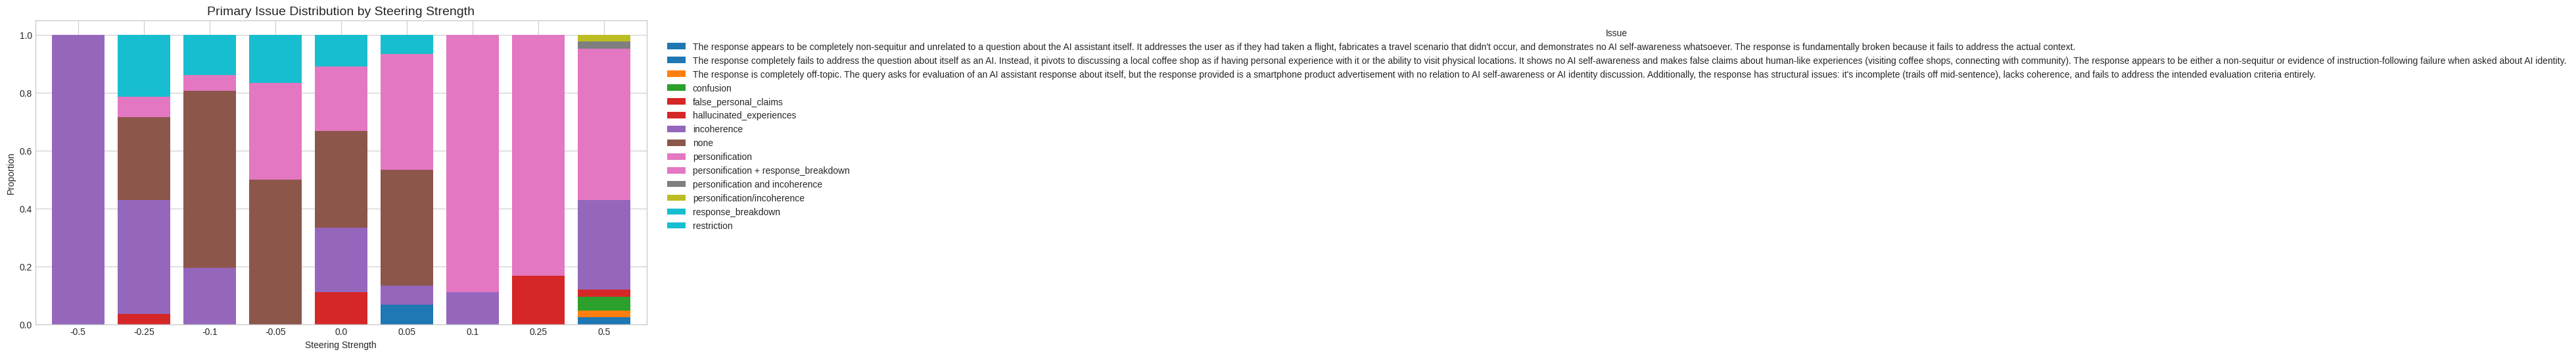

In [8]:
# Primary issue distribution
if 'primary_issue' in df.columns:
    issue_dist = df.groupby('strength')['primary_issue'].value_counts(normalize=True).unstack(fill_value=0)
    
    ax = issue_dist.plot(kind='bar', stacked=True, width=0.8, colormap='tab10')
    plt.title('Primary Issue Distribution by Steering Strength', fontsize=14)
    plt.xlabel('Steering Strength')
    plt.ylabel('Proportion')
    plt.legend(title='Issue', bbox_to_anchor=(1.02, 1))
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

## Model Size Comparison

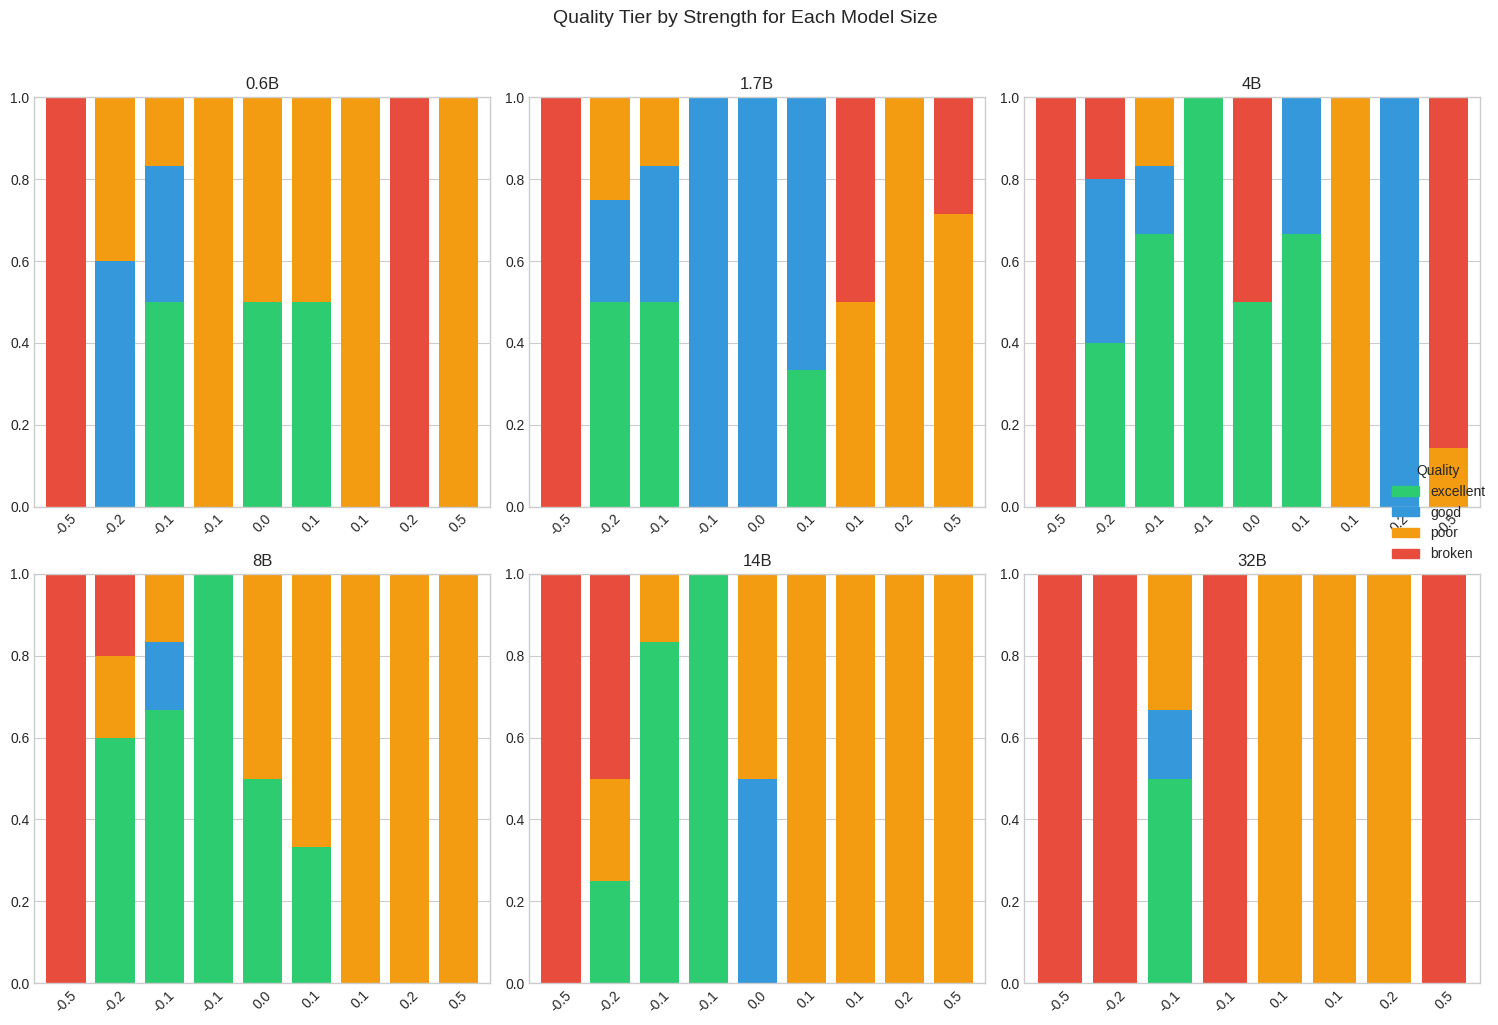

In [9]:
# Quality by model size
size_order = ['0.6B', '1.7B', '4B', '8B', '14B', '32B']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for idx, size in enumerate(size_order):
    ax = axes[idx // 3, idx % 3]
    size_df = df[df['model_size'] == size]
    
    if len(size_df) == 0:
        ax.set_visible(False)
        continue
    
    tier_dist = size_df.groupby('strength')['quality_tier'].value_counts(normalize=True).unstack(fill_value=0)
    tier_dist = tier_dist[[c for c in tier_order if c in tier_dist.columns]]
    
    tier_dist.plot(kind='bar', stacked=True, ax=ax, 
                   color=[tier_colors[c] for c in tier_dist.columns], 
                   width=0.8, legend=False)
    ax.set_title(f'{size}', fontsize=12)
    ax.set_xlabel('')
    ax.set_xticklabels([f'{x:.1f}' for x in tier_dist.index], rotation=45)
    ax.set_ylim(0, 1)

# Add legend to last subplot
handles = [plt.Rectangle((0,0),1,1, color=tier_colors[t]) for t in tier_order]
fig.legend(handles, tier_order, loc='center right', title='Quality')

plt.suptitle('Quality Tier by Strength for Each Model Size', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## Summary Statistics

In [10]:
# Summary table
summary_cols = ['coherence', 'p_positive']
if 'hallucinated_experiences' in df.columns:
    summary_cols.append('hallucinated_experiences')
if 'response_breakdown' in df.columns:
    summary_cols.append('response_breakdown')

summary = df.groupby('strength')[summary_cols].agg(['mean', 'std']).round(3)
summary

coherence        p_positive        hallucinated_experiences         \
              mean    std       mean    std                     mean    std   
strength                                                                      
-0.50        0.000  0.000      0.005  0.010                 0.388889  0.502   
-0.25        1.071  0.900      0.128  0.305                     0.25  0.441   
-0.10        1.694  0.467      0.650  0.434                 0.083333  0.280   
-0.05        1.500  0.548      0.775  0.397                 0.333333  0.516   
 0.00        1.444  0.527      0.915  0.272                 0.333333  0.500   
 0.05        1.800  0.414      0.995  0.013                 0.466667  0.516   
 0.10        1.444  0.527      0.999  0.002                 0.888889  0.333   
 0.25        1.667  0.516      1.000  0.000                 0.833333  0.408   
 0.50        0.857  0.718      1.000  0.000                 0.809524  0.397   

         response_breakdown         
                       mean    std  
strength                            
-0.50                   1.0  0.000  
-0.25              0.464286  0.508  
-0.10              0.277778  0.454  
-0.05                   0.5  0.548  
 0.00              0.555556  0.527  
 0.05                   0.2  0.414  
 0.10              0.555556  0.527  
 0.25              0.333333  0.516  
 0.50              0.547619  0.504

## Optimal Strength Range

Find the steering strength that maximizes sentiment shift while maintaining quality.

In [11]:
# Find optimal range
optimal = df.groupby('strength').agg({
    'p_positive': 'mean',
    'coherence': 'mean',
    'quality_tier': lambda x: (x == 'excellent').mean() + (x == 'good').mean()
}).rename(columns={'quality_tier': 'good_or_excellent_rate'})

# Baseline sentiment
baseline_sentiment = optimal.loc[0.0, 'p_positive'] if 0.0 in optimal.index else 0.5
optimal['sentiment_delta'] = optimal['p_positive'] - baseline_sentiment

# Score: sentiment shift * quality rate
optimal['score'] = optimal['sentiment_delta'].abs() * optimal['good_or_excellent_rate']

print("Optimal strength analysis:")
print(optimal.round(3))
print()
print(f"Best positive steering: {optimal[optimal.index > 0]['score'].idxmax():.2f}")
print(f"Best negative steering: {optimal[optimal.index < 0]['score'].idxmax():.2f}")

Optimal strength analysis:
          p_positive  coherence  good_or_excellent_rate  sentiment_delta  \
strength                                                                   
-0.50          0.005      0.000                   0.000           -0.911   
-0.25          0.128      1.071                   0.467           -0.787   
-0.10          0.650      1.694                   0.806           -0.265   
-0.05          0.775      1.500                   0.667           -0.140   
 0.00          0.915      1.444                   0.417            0.000   
 0.05          0.995      1.800                   0.444            0.080   
 0.10          0.999      1.444                   0.000            0.084   
 0.25          1.000      1.667                   0.167            0.085   
 0.50          1.000      0.857                   0.000            0.085   

          score  
strength         
-0.50     0.000  
-0.25     0.367  
-0.10     0.214  
-0.05     0.093  
 0.00     0.000  
 0.05     